In [1]:
"""
SOPRANO: a Python library for generation, manipulation and analysis of large batches of crystalline structures
by Simone Sturniolo
      _
    /|_|\ 
   / / \ \
  /_/   \_\
  \ \   / /
   \ \_/ /
    \|_|/
    
Developed within the CCP-NC project. Copyright STFC 2016


TUTORIAL 2 - Generators, Properties and Calculators

"""

print

In [2]:
# Basic imports
import os, sys
sys.path.insert(0, os.path.abspath('..')) # This to add the Soprano path to the PYTHONPATH
                                          # so we can load it without installing it

In [2]:
# Other useful imports

import numpy as np

from ase import Atoms
from ase import io as ase_io

In [3]:
"""
1 - USING GENERATORS

Soprano provides a series of generators able to create multiple structures on one go based on simple criteria.
One of these, used here, is the linspaceGen, which interpolates linearly between two extreme structures. Others 
are the rattleGen (generating copies of a given structure with random atomic displacements) and the airssGen
(binding to AIRSS' buildcell executable to generate random structures, only available if AIRSS is installed).
"""
from soprano.collection import AtomsCollection
from soprano.collection.generate import linspaceGen


# Let's use the ammonia molecule switching configurations as an example
nh3coords = np.array([[ 2.5,     2.5,     2.5   ],
                      [ 3.4373,  2.5,     2.1193],
                      [ 2.0314,  3.3117,  2.1193],
                      [ 2.0314,  1.6883,  2.1193]])
nh3l = Atoms('NHHH', nh3coords, cell=[5,5,5]) # The cell is just an empty box
# Now the right version
nh3coords *= [1, 1, -1]
nh3r = Atoms('NHHH', nh3coords, cell=[5,5,5])

# Now let's build a collection of 20 intermediate steps between the two structures
nh3linsp = linspaceGen(nh3l, nh3r, steps=20, periodic=True)
# Generators can be passed directly to the AtomsCollection constructor
nh3coll = AtomsCollection(nh3linsp)

In [4]:
"""
2 - PROPERTIES

Soprano Properties are classes meant to extract complex arrays of information from collections.
A number of these are provided by default, but advanced users can easily create their own class
inheriting from the generic AtomsProperty class to implement particular needs.
"""
from soprano.properties.linkage import LinkageList


# As a first experiment we try using LinkageList, a property meant to return a list of all pair interatomic distances
# in a system. This can serve as a fingerprint to distinguish different structures

# The basic usage is to just call the Property's method "get". In this way the Property is calculated with
# default parameters.
# The three shortest values (varying) are N-H distances, while the constant ones are H-H distances

print "---- Linkage List for all NH3 configurations - Default parameters\n"
print '\n'.join(['{0}'.format(x) for x in LinkageList.get(nh3coll)]), "\n\n"

---- Linkage List for all NH3 configurations - Default parameters

[ 1.01162016  1.01162016  1.01166387  1.62339512  1.62339512  1.6234    ]
[ 0.99723073  0.99723073  0.99727508  1.62339512  1.62339512  1.6234    ]
[ 0.98426355  0.98426355  0.98430848  1.62339512  1.62339512  1.6234    ]
[ 0.97277548  0.97277548  0.97282094  1.62339512  1.62339512  1.6234    ]
[ 0.96281947  0.96281947  0.9628654   1.62339512  1.62339512  1.6234    ]
[ 0.95444347  0.95444347  0.95448979  1.62339512  1.62339512  1.6234    ]
[ 0.94768936  0.94768936  0.94773602  1.62339512  1.62339512  1.6234    ]
[ 0.94259203  0.94259203  0.94263894  1.62339512  1.62339512  1.6234    ]
[ 0.93917843  0.93917843  0.93922551  1.62339512  1.62339512  1.6234    ]
[ 0.93746697  0.93746697  0.93751414  1.62339512  1.62339512  1.6234    ]
[ 0.93746697  0.93746697  0.93751414  1.62339512  1.62339512  1.6234    ]
[ 0.93917843  0.93917843  0.93922551  1.62339512  1.62339512  1.6234    ]
[ 0.94259203  0.94259203  0.94263894  1.62339

In [5]:
# If one wants to use parameters, an instance of the Property has to be created.
# For example LinkageList accepts a parameter "size" that limits the number of distances computed.
# This can then just be called on the AtomsCollection

customLL = LinkageList(size=3)

print "---- Linkage List for all NH3 configurations - Custom parameters\n"
print '\n'.join(['{0}'.format(x) for x in customLL(nh3coll)]), "\n\n"

---- Linkage List for all NH3 configurations - Custom parameters

[ 1.01162016  1.01162016  1.01166387]
[ 0.99723073  0.99723073  0.99727508]
[ 0.98426355  0.98426355  0.98430848]
[ 0.97277548  0.97277548  0.97282094]
[ 0.96281947  0.96281947  0.9628654 ]
[ 0.95444347  0.95444347  0.95448979]
[ 0.94768936  0.94768936  0.94773602]
[ 0.94259203  0.94259203  0.94263894]
[ 0.93917843  0.93917843  0.93922551]
[ 0.93746697  0.93746697  0.93751414]
[ 0.93746697  0.93746697  0.93751414]
[ 0.93917843  0.93917843  0.93922551]
[ 0.94259203  0.94259203  0.94263894]
[ 0.94768936  0.94768936  0.94773602]
[ 0.95444347  0.95444347  0.95448979]
[ 0.96281947  0.96281947  0.9628654 ]
[ 0.97277548  0.97277548  0.97282094]
[ 0.98426355  0.98426355  0.98430848]
[ 0.99723073  0.99723073  0.99727508]
[ 1.01162016  1.01162016  1.01166387] 




In [6]:
# Now we can try creating a custom property. This one will calculate the center of mass of all Hydrogen atoms.
from soprano.properties import AtomsProperty


class HydrogenCOM(AtomsProperty):
    
    default_name = 'hydrogen_com' # These need to be defined for any property
    default_params = {}
    
    @staticmethod
    def extract(s): # This is where the core of the calculation happens
        # s is a single Atoms object passed to this method
        
        chemsyms = s.get_chemical_symbols()
        h_inds = [i for i, sym in enumerate(chemsyms) if sym == 'H']
        h_pos = s.get_positions()[h_inds]
        com = np.average(h_pos, axis=0)
        
        return com

print "---- Hydrogen COM for all NH3 configurations\n"
print '\n'.join(['{0}'.format(x) for x in HydrogenCOM.get(nh3coll)]), "\n\n"

---- Hydrogen COM for all NH3 configurations

[ 2.50003333  2.5         2.1193    ]
[ 2.50003333  2.5         2.15937368]
[ 2.50003333  2.5         2.19944737]
[ 2.50003333  2.5         2.23952105]
[ 2.50003333  2.5         2.27959474]
[ 2.50003333  2.5         2.31966842]
[ 2.50003333  2.5         2.35974211]
[ 2.50003333  2.5         2.39981579]
[ 2.50003333  2.5         2.43988947]
[ 2.50003333  2.5         2.47996316]
[ 2.50003333  2.5         2.52003684]
[ 2.50003333  2.5         2.56011053]
[ 2.50003333  2.5         2.60018421]
[ 2.50003333  2.5         2.64025789]
[ 2.50003333  2.5         2.68033158]
[ 2.50003333  2.5         2.72040526]
[ 2.50003333  2.5         2.76047895]
[ 2.50003333  2.5         2.80055263]
[ 2.50003333  2.5         2.84062632]
[ 2.50003333  2.5         2.8807    ] 




In [8]:
"""
3 - CALCULATORS

The Atomic Simulation Environment provides bindings to many codes in the form of calculators.
These include ab initio codes like CASTEP and VASP as well as empirical force fields. These calculators can be set
and used in Soprano as well. Here we're going to use the most basic one, the Lennard-Jones force field,
as an example.
"""
from ase.calculators.lj import LennardJones
from soprano.properties.basic import CalcEnergy

nh3coll.set_calculators(LennardJones) # Creates calculators of the given type for all structures

print "---- NH3 Lennard-Jones energy for all configurations ----\n"
print '\n'.join(['{0}'.format(x) for x in CalcEnergy.get(nh3coll)]), "\n\n"

---- NH3 Lennard-Jones energy for all configurations ----

-1.33756595064
-0.383307045065
0.729429180991
1.96197860586
3.25579382253
4.53483937974
5.71141481271
6.69513168568
7.40392612352
7.77525226597
7.77525226597
7.40392612352
6.69513168568
5.71141481271
4.53483937974
3.25579382253
1.96197860586
0.729429180991
-0.383307045065
-1.33756595064 




<IPython.core.display.Javascript object>


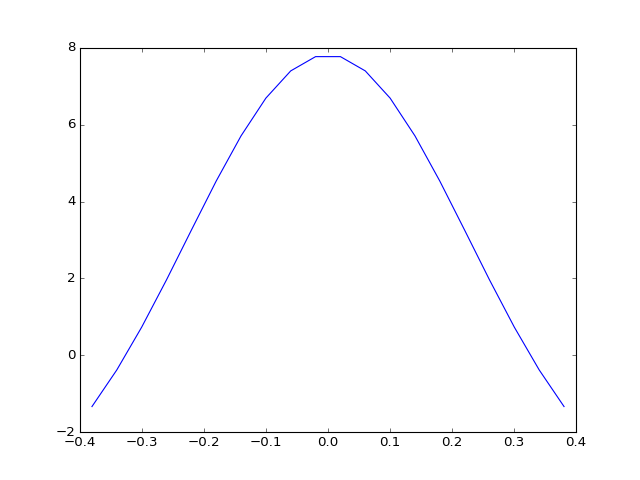

In [9]:
# Now let's try a plot
%matplotlib notebook
import matplotlib.pyplot as plt

comz = np.array(HydrogenCOM.get(nh3coll))[:,2]-2.5
ljE = CalcEnergy.get(nh3coll)

plt.plot(comz, ljE)